In [1]:
pip install tweepy pandas nltk gensim wordcloud plotly dash

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 15.8 MB/s eta 0:00:00


In [70]:
import requests

# Fetch news from NewsAPI
def fetch_news(api_key, query, page_size=50):
    url = f'https://newsapi.org/v2/everything?q={query}&pageSize={page_size}&apiKey={api_key}'
    response = requests.get(url)
    return response.json()

# API key for NewsAPI
api_key = '9eba6c1dff3e42bc84ab554699ea1fb5'

# Various topics to fetch news
topics = ['technology', 'sports', 'health', 'business', 'entertainment', 'science', 'world', 'politics', 'education', 'travel']

news_data = {}
for topic in topics:
    news_data[topic] = fetch_news(api_key, topic)['articles']


In [73]:
# Import necessry libraries
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from gensim import corpora
import gensim
import nltk

# Download NLTK stopwords for text processing
nltk.download('stopwords')
nltk.download('punkt')

# Process text with removing stopwords and removing
def process_text(articles):
    # combine title and description text in a single string
    text_data = " ".join([article['title'] + ' ' + article['description'] for article in articles if article['title'] and article['description']])
    # remove single characters, unwanted characters and stopwords
    words = re.findall(r'\b\w+\b', text_data.lower())
    stop_words = set(stopwords.words('english'))
    filtered_words = [word for word in words if len(word) > 1 and word not in stop_words]
    return filtered_words

# Create processed text dictionary with topic and article keys
processed_texts = {topic: process_text(articles) for topic, articles in news_data.items()}

# Combine all texts for LDA
all_texts = sum(processed_texts.values(), [])

# Create Dictionary with id2word
id2word = corpora.Dictionary([all_texts])

# Create Corpus: Term Document Frequency
texts = [processed_texts[topic] for topic in topics]
corpus = [id2word.doc2bow(text) for text in texts]


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [74]:
# Number of topics for LDA model
num_topics = 10

# Build LDA model with passing parameters of data, topics, etc
lda_model = gensim.models.LdaModel(corpus=corpus,
                                   id2word=id2word,
                                   num_topics=num_topics,
                                   random_state=100,
                                   update_every=1,
                                   chunksize=100,
                                   passes=10,
                                   alpha='auto',
                                   per_word_topics=True)

# Print the topics in LDA model
topics = lda_model.print_topics()
for topic in topics:
    print(topic)


(0, '0.023*"health" + 0.018*"travel" + 0.010*"new" + 0.007*"apple" + 0.006*"features" + 0.005*"time" + 0.005*"removed" + 0.005*"samsung" + 0.004*"one" + 0.004*"year"')
(1, '0.000*"new" + 0.000*"world" + 0.000*"ai" + 0.000*"business" + 0.000*"science" + 0.000*"politics" + 0.000*"removed" + 0.000*"health" + 0.000*"one" + 0.000*"sports"')
(2, '0.000*"new" + 0.000*"business" + 0.000*"health" + 0.000*"world" + 0.000*"ai" + 0.000*"sports" + 0.000*"cup" + 0.000*"says" + 0.000*"removed" + 0.000*"one"')
(3, '0.000*"ai" + 0.000*"new" + 0.000*"world" + 0.000*"travel" + 0.000*"business" + 0.000*"apple" + 0.000*"entertainment" + 0.000*"us" + 0.000*"removed" + 0.000*"education"')
(4, '0.027*"science" + 0.010*"ai" + 0.007*"new" + 0.006*"musk" + 0.005*"data" + 0.004*"make" + 0.004*"read" + 0.004*"meta" + 0.004*"voyager" + 0.004*"space"')
(5, '0.014*"sports" + 0.010*"education" + 0.010*"new" + 0.007*"college" + 0.006*"football" + 0.006*"betting" + 0.006*"25" + 0.005*"ai" + 0.005*"post" + 0.005*"reading

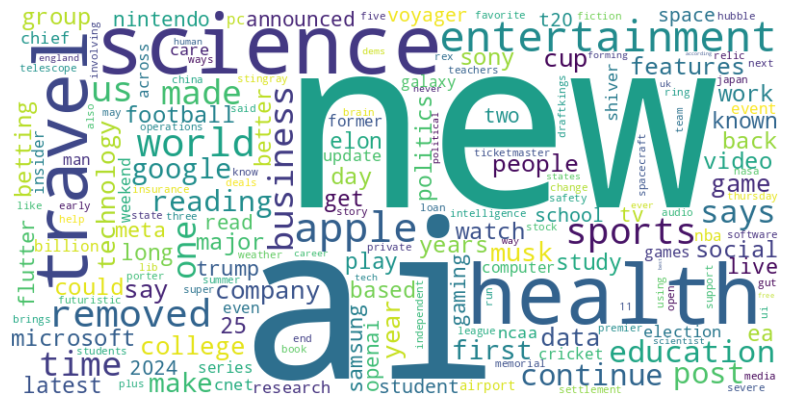

In [75]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Combine all topic words and their frequencies with dictionary
word_freq = {}
for i in range(lda_model.num_topics):
    for word, freq in lda_model.show_topic(i, topn=50):
        word_freq[word] = word_freq.get(word, 0) + freq

# Generate word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


Topic: health travel new 
Words: ['health', 'travel', 'new', 'apple', 'features', 'time', 'removed', 'samsung', 'one', 'year']

Topic: new world ai 
Words: ['new', 'world', 'ai', 'business', 'science', 'politics', 'removed', 'health', 'one', 'sports']

Topic: new business health 
Words: ['new', 'business', 'health', 'world', 'ai', 'sports', 'cup', 'says', 'removed', 'one']

Topic: ai new world 
Words: ['ai', 'new', 'world', 'travel', 'business', 'apple', 'entertainment', 'us', 'removed', 'education']

Topic: science ai new 
Words: ['science', 'ai', 'new', 'musk', 'data', 'make', 'read', 'meta', 'voyager', 'space']

Topic: sports education new 
Words: ['sports', 'education', 'new', 'college', 'football', 'betting', '25', 'ai', 'post', 'reading']

Topic: ai new health 
Words: ['ai', 'new', 'health', 'apple', 'entertainment', 'business', 'education', 'politics', 'world', 'travel']

Topic: world ai business 
Words: ['world', 'ai', 'business', 'new', 'technology', 'us', 'politics', 'removed

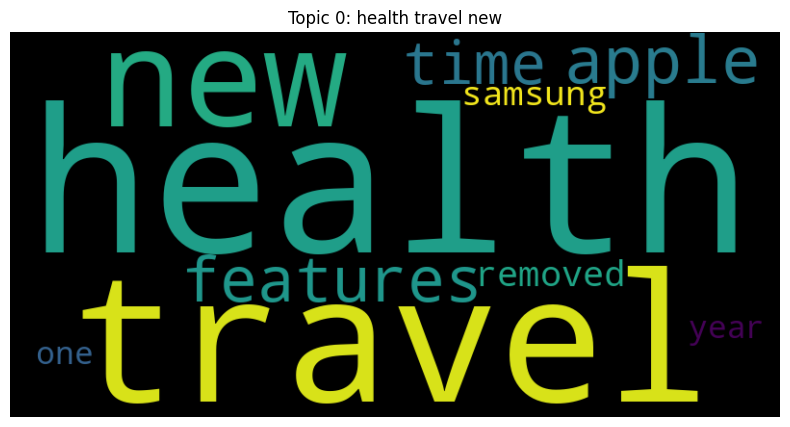

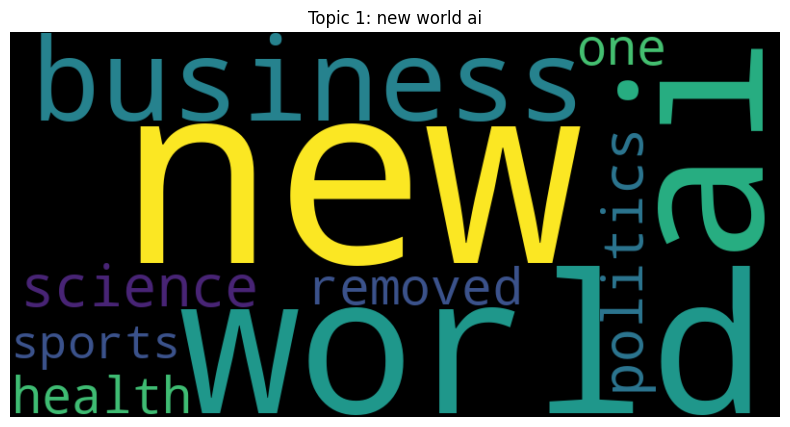

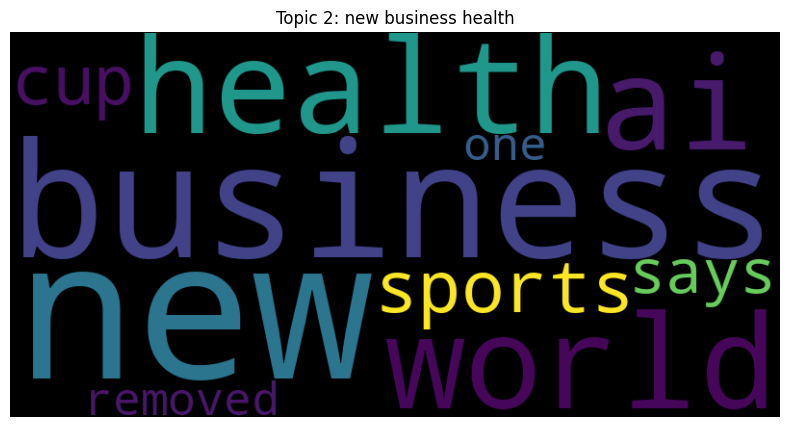

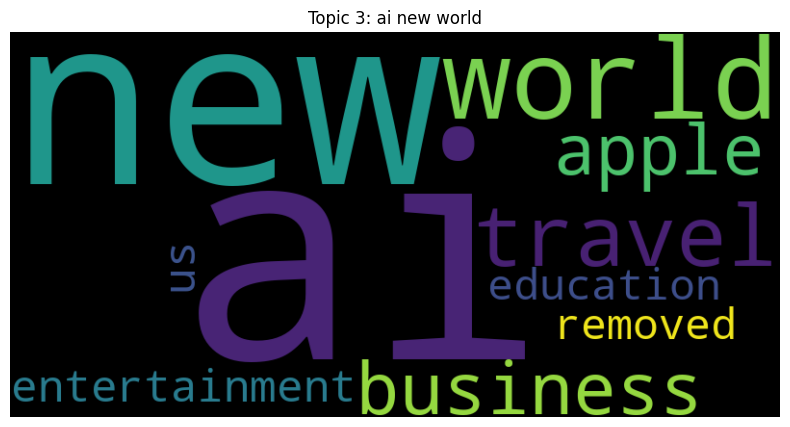

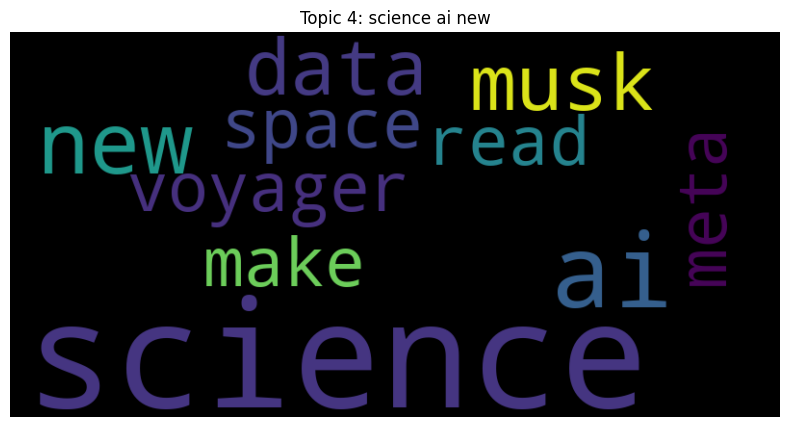

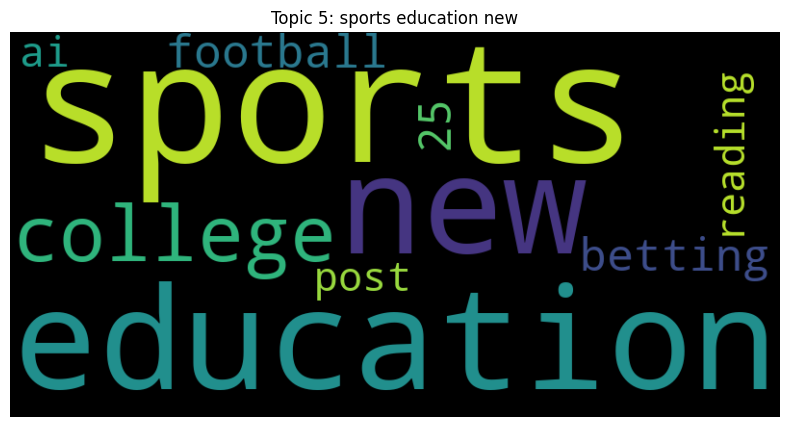

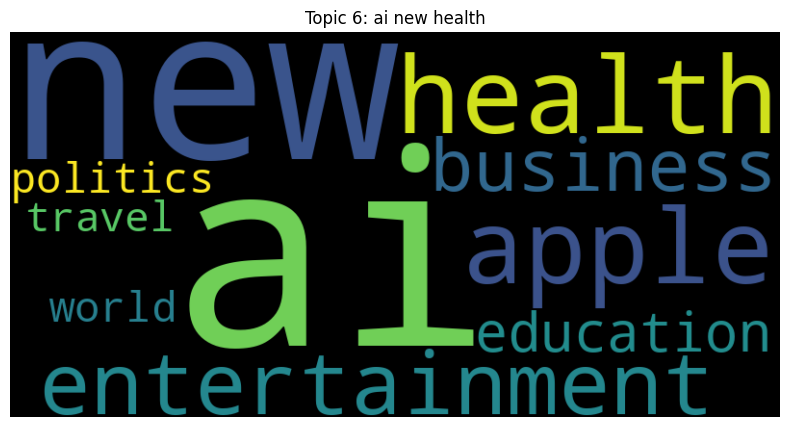

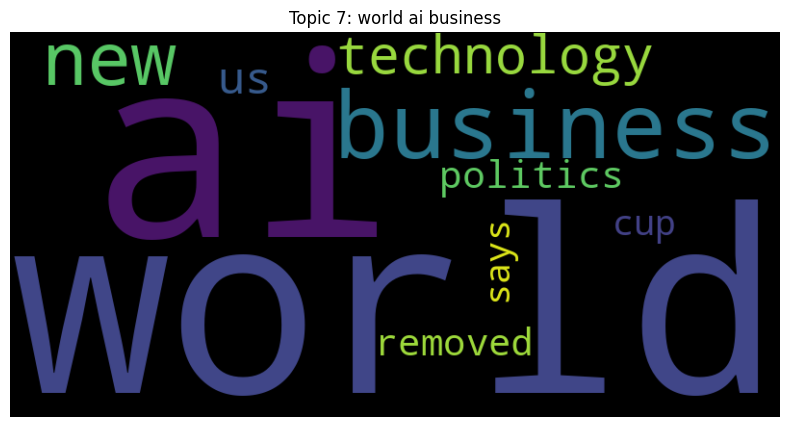

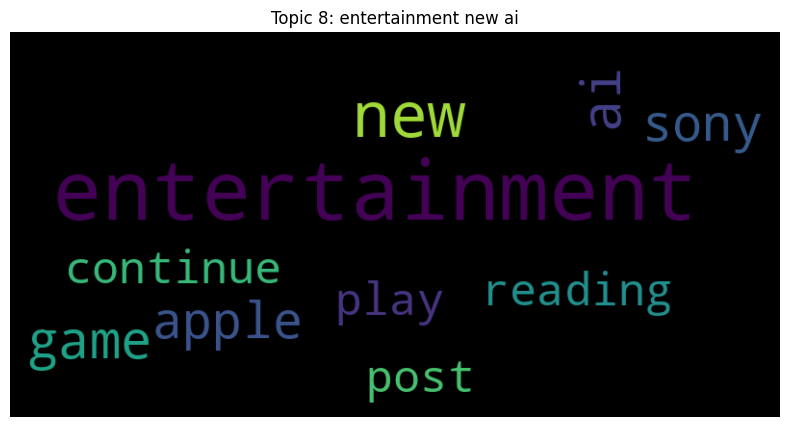

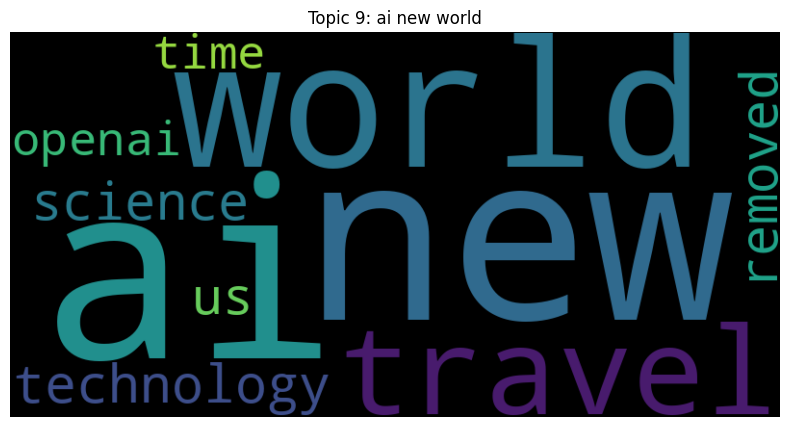

In [76]:
# Code to generate word cloud for each topic
from gensim import corpora
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Generate automatic topic names and word clouds
def generate_topic_name(words):
    return ' '.join([word for word, _ in words[:3]])

topic_words = lda_model.show_topics(formatted=False)

# Create a dictionary to store topic names
topic_names = {i: generate_topic_name(words) for i, words in topic_words}

# Print topics with generated names
for idx, words in topic_words:
    topic_name = topic_names.get(idx, f"Topic {idx}")
    print(f"Topic: {topic_name} \nWords: {[word for word, _ in words]}\n")

# Create word clouds for each topic
for idx, words in topic_words:
    word_freq = {word: freq for word, freq in words}
    wordcloud = WordCloud(width=800, height=400).generate_from_frequencies(word_freq)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(f"Topic {idx}: {topic_names[idx]}")
    plt.show()

In [77]:
# Function to get topic distribution for each document
def get_document_topics(model, corpus):
    topic_distribution = model.get_document_topics(corpus, minimum_probability=0)
    return topic_distribution

# Get topic distributions for the entire corpus
topic_distributions = get_document_topics(lda_model, corpus)

# Summarize topic distributions
topic_summaries = [0] * num_topics
for doc in topic_distributions:
    for topic_num, prob in doc:
        topic_summaries[topic_num] += prob

# Get top-5 topics
top_5_topics = sorted(range(len(topic_summaries)), key=lambda i: topic_summaries[i], reverse=True)[:5]


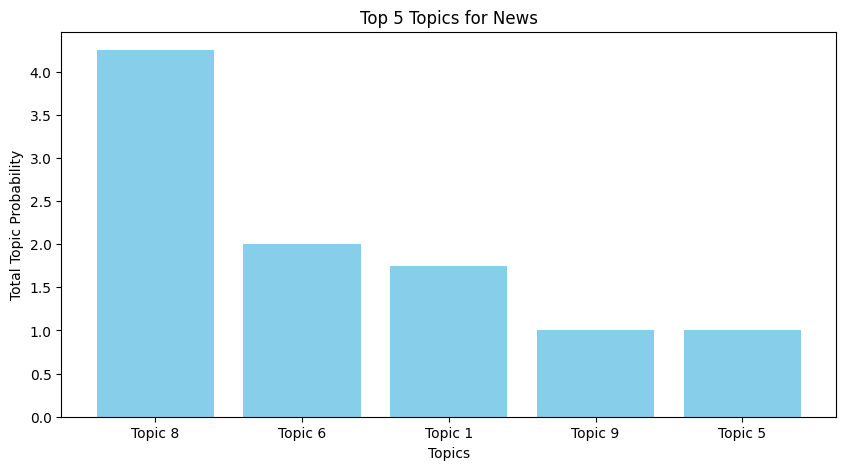

In [86]:
import matplotlib.pyplot as plt

# Get topic labels and their probabilities
labels = [f"Topic {i+1}" for i in top_5_topics]
values = [topic_summaries[i] for i in top_5_topics]

# Create bar chart for Top 5 topics
plt.figure(figsize=(10, 5))
plt.bar(labels, values, color='skyblue')
plt.xlabel('Topics')
plt.ylabel('Total Topic Probability')
plt.title('Top 5 Topics for News')
plt.show()


In [81]:
# Search news function to search word in articles
def search_news(word, processed_news_data):
    word = word.lower()
    related_articles = []
    for topic, articles in processed_news_data.items():
        for article in articles:
            if word in article['filtered_text']:
                related_articles.append(article)
    return related_articles


In [88]:
# Function to display related articles for searched topic word
def display_related_news(word, related_articles):
    if related_articles:
        print(f"Articles related to '{word}':")
        for i, article in enumerate(related_articles, 1):
            print(f"\n{i}. Title: {article['title']}")
            print(f"   Description: {article['description']}")
    else:
        print(f"No articles found related to '{word}'.")

# Use function to search input word
word = input("Enter a word to search for related news: ")
related_articles = search_news(word, news_data)
display_related_news(word, related_articles)


Enter a word to search for related news: ai
Articles related to 'ai':

1. Title: Elon Musk drops lawsuit against OpenAI
   Description: Elon Musk was suing ChatGPT maker OpenAI and its CEO, Sam Altman, for a breach of contract, but now the lawsuit has been dropped.

2. Title: Amazon-Powered AI Cameras Used to Detect Emotions of Unwitting UK Train Passengers
   Description: CCTV cameras and AI are being combined to monitor crowds, detect bike thefts, and spot trespassers.

3. Title: Musk withdraws his breach of contract lawsuit against OpenAI
   Description: Elon Musk dropped a lawsuit against OpenAI one day before a judge in California state court was set to hear OpenAI’s request for dismissal. Musk’s suit, which was filed in February, had accused OpenAI co-founders Sam Altman and Greg Brockman of violating the …

4. Title: US-supplied HIMARS 'completely ineffective' against superior Russian jamming technology, report says
   Description: Russian jamming can cause the HIMAR missiles to